## Setup

In [1]:
from pprint import pprint
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Setup spark session
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.102:7077") \
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","100s")\
        .config("spark.executor.cores",4)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .appName("Analyse-1")\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

22/03/15 00:33:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/15 00:33:41 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


## Import data

In [2]:
#Import data
data_frame = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.102:9000/data_q4_2021/*.csv')\
    .cache()
data_frame.rdd.getNumPartitions()

92

## Number of drives

In [3]:
num_drives_by_date = data_frame.groupBy("date").count().orderBy("date").collect()

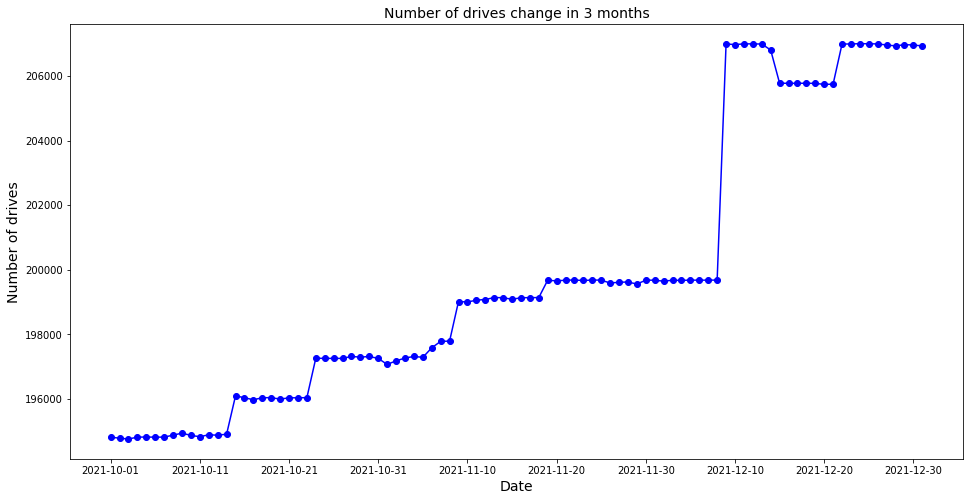

In [22]:
# Plot result
plt.figure(figsize=(16,8))
plt.plot([a[0] for a in num_drives_by_date], [a[1] for a in num_drives_by_date], color='blue', marker='o')
plt.title('Number of drives change in 3 months', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of drives', fontsize=14)
plt.xticks(range(0,len(num_drives_by_date),10))
plt.show()

## Failed drives

In [23]:
num_failures_by_date = data_frame.filter(data_frame["failure"] == 1).groupBy("date").count().orderBy("date").collect()

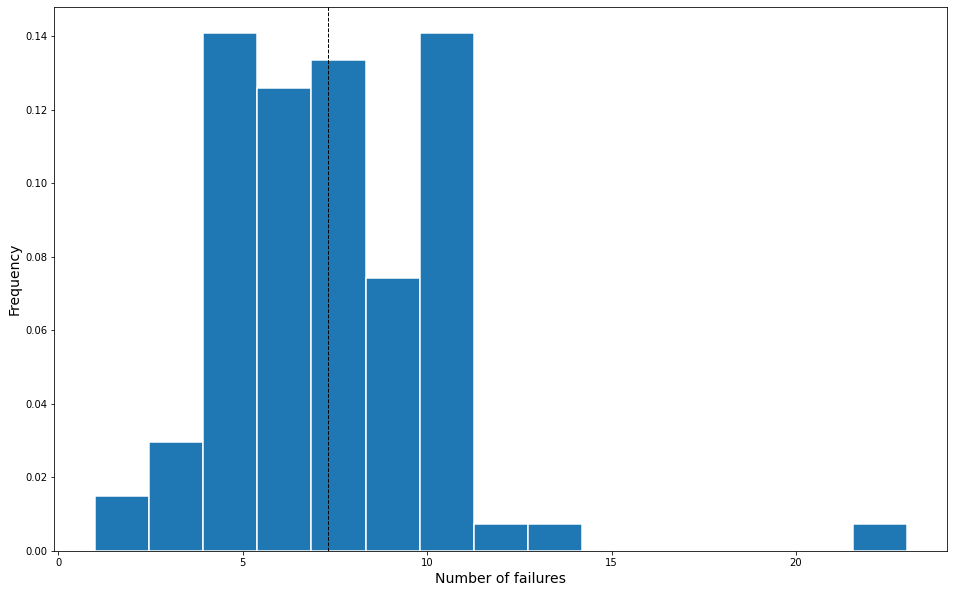

In [35]:
import numpy as np
#Number of failures list
x = [a[1] for a in num_failures_by_date]

plt.figure(figsize=(16,10))
plt.hist(x, density=True, bins=15, edgecolor='white', linewidth=1.5)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Number of failures',fontsize=14);
plt.axvline(np.mean(np.array(x)), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
spark_session.stop()